In [51]:
%load_ext autoreload
%autoreload 2

TORCH_ACCELERATOR = "cpu"

import os
if TORCH_ACCELERATOR == "cpu":
    os.environ["CUDA_VISIBLE_DEVICES"] = ""

import math
import multiprocessing
import heapq
import dataclasses
import itertools
import collections

import torchvision.models as models
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms.v2 as T
import numpy as np
import pandas
import matplotlib.pyplot as plt

import lightning as L
from lightning.pytorch.loggers import TensorBoardLogger

import torchmetrics
import webdataset as wds
import s2sphere
import tqdm

import label_mapping
from datasets import Im2gps2007, Im2gpsTest

LOAD_CHECKPOINT_MAP_LOCATION = {}
if TORCH_ACCELERATOR == "cpu":
    LOAD_CHECKPOINT_MAP_LOCATION = {"map_location": torch.device("cpu")}

torch.cuda.is_available()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


True

In [2]:
im2gps2007 = Im2gps2007()
train_dataloader = im2gps2007.train_dataloader()
val_dataloader = im2gps2007.val_dataloader()

Unknown device: NVIDIA GeForce GTX 1070
Unknown device: NVIDIA GeForce GTX 1070


In [3]:
from s2cell_mnet3 import S2CellClassifierMnet3

mnet3_model = S2CellClassifierMnet3(
    num_classes=len(im2gps2007.mapping),
    learning_rate=1e-3,
    freeze_features=False,
)

# Quick test run
L.Trainer(
    accelerator=TORCH_ACCELERATOR,
    fast_dev_run=True,
).fit(model=mnet3_model, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Running in `fast_dev_run` mode: will run the requested loop using 1 batch(es). Logging and checkpointing is suppressed.
/home/fyhuang/dev/mlenv/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:617: UserWarning: Checkpoint directory /home/fyhuang/LocalProjects/img2loc/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type               | Params
--------------------------------------------------
0 | features   | Sequential         | 3.0 M 
1 | avgpool    | AdaptiveAvgPool2d  | 0     
2 | classifier | Sequential         | 5.6 M 
3 | accuracy   | MulticlassAccuracy | 0     
--------------------------------------------------
8.6 M     Trainable params
0         Non-trainable params
8.6 M     

Epoch 0: 100%|██████████| 1/1 [00:02<00:00,  2.37s/it, train_loss=7.590, train_acc_step=0.000, val_loss=7.740]

`Trainer.fit` stopped: `max_steps=1` reached.


Epoch 0: 100%|██████████| 1/1 [00:02<00:00,  2.37s/it, train_loss=7.590, train_acc_step=0.000, val_loss=7.740]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/fyhuang/dev/mlenv/lib/python3.11/site-packages/lightning/pytorch/loops/utilities.py:72: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
Finding best initial lr:  87%|████████▋ | 87/100 [00:12<00:01,  6.92it/s]
LR finder stopped early after 87 steps due to diverging loss.
Learning rate set to 0.0013182567385564075
Restoring states from the checkpoint path at /home/fyhuang/LocalProjects/img2loc/.lr_find_851a5eee-73b0-45f8-aa8a-060af661bab3.ckpt
Restored all states from the checkpoint at /home/fyhuang/LocalProjects/img2loc/.lr_find_851a5eee-73b0-45f8-aa8a-060af661bab3.ckpt


{'lr': [1e-08, 1.4454397707459274e-08, 1.7378008287493753e-08, 2.0892961308540398e-08, 2.51188643150958e-08, 3.019951720402016e-08, 3.630780547701014e-08, 4.36515832240166e-08, 5.248074602497726e-08, 6.309573444801934e-08, 7.585775750291837e-08, 9.120108393559096e-08, 1.0964781961431852e-07, 1.3182567385564074e-07, 1.5848931924611133e-07, 1.9054607179632475e-07, 2.2908676527677735e-07, 2.7542287033381663e-07, 3.311311214825911e-07, 3.9810717055349735e-07, 4.786300923226383e-07, 5.75439937337157e-07, 6.918309709189366e-07, 8.317637711026709e-07, 1e-06, 1.2022644346174132e-06, 1.445439770745928e-06, 1.7378008287493761e-06, 2.089296130854039e-06, 2.5118864315095797e-06, 3.0199517204020163e-06, 3.630780547701014e-06, 4.365158322401661e-06, 5.248074602497728e-06, 6.3095734448019305e-06, 7.585775750291836e-06, 9.120108393559096e-06, 1.0964781961431852e-05, 1.3182567385564076e-05, 1.584893192461114e-05, 1.9054607179632464e-05, 2.2908676527677725e-05, 2.7542287033381663e-05, 3.311311214825911e

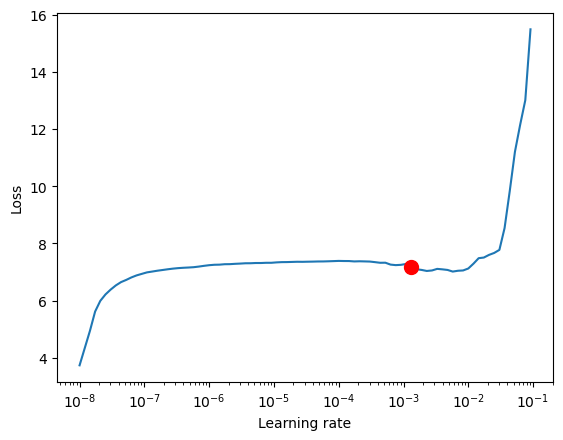

In [10]:
# LR finder
mnet3_model = S2CellClassifierMnet3(
    num_classes=len(im2gps2007.mapping),
    learning_rate=1e-3,
    freeze_features=False,
)

lr_finder = L.pytorch.tuner.Tuner(
    L.Trainer(
        accelerator=TORCH_ACCELERATOR,
        enable_checkpointing=False,
        logger=False,
    )
).lr_find(mnet3_model, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)

print(lr_finder.results)
fig = lr_finder.plot(suggest=True)
fig.show()

# Testing

In [35]:
# Run inference on test set. Measure accuracy using PlaNet criteria
def radians_s2cell_latlng(s2cell, lat, lng):
    pred_center = s2sphere.Cell(s2sphere.CellId.from_token(s2cell)).get_center()
    pred_latlng = s2sphere.LatLng.from_point(pred_center)
    true_latlng = s2sphere.LatLng.from_degrees(lat, lng)
    angle = true_latlng.get_distance(pred_latlng)
    return angle.radians

@dataclasses.dataclass(order=True)
class DistancePrediction:
    distance: float
    pred_s2cell: str
    lat: float
    lng: float
    img: torch.Tensor=dataclasses.field(compare=False)

def predict_all(model, test_dataloader, max_steps=None):
    results = {
        "pred_token": [],
        "true_lat": [],
        "true_lng": [],
    }

    least_accurate_n = []

    if max_steps is not None:
        test_dataloader = itertools.islice(test_dataloader, max_steps)

    model.eval()
    with torch.no_grad():
        for inputs, targets in tqdm.tqdm(test_dataloader):
            logits = model.predict_step(inputs, 0)
            pred_t = torch.argmax(logits, dim=1)

            for ix, pred in enumerate(pred_t.flatten()):
                pred_s2cell = im2gps2007.mapping.get_name(pred.item())

                results["pred_token"].append(pred_s2cell)
                (lat, lng) = (targets[ix][0], targets[ix][1])
                results["true_lat"].append(lat)
                results["true_lng"].append(lng)

                # Maintain list of the most inaccurate predictions
                distance = radians_s2cell_latlng(pred_s2cell, lat, lng)
                heapq.heappush(
                    least_accurate_n,
                    DistancePrediction(distance, pred_s2cell, lat, lng, inputs[ix].cpu())
                )
                if len(least_accurate_n) > 10:
                    heapq.heappop(least_accurate_n)
    return pandas.DataFrame(results), least_accurate_n

mnet3_model = S2CellClassifierMnet3.load_from_checkpoint(
    "checkpoints/s2cell_predict/version3.ckpt",
    num_classes=len(im2gps2007.mapping),
    **LOAD_CHECKPOINT_MAP_LOCATION
)
results, least_accurate_n = predict_all(
    mnet3_model,
    #Im2gpsTest().test_dataloader_3k(),
    im2gps2007.val_dataloader_latlng(),
    #max_steps=1000,
)
results

Unknown device: NVIDIA GeForce GTX 1070


59144it [30:29, 32.32it/s]


,pred_token,true_lat,true_lng
0,8701,tensor(31.5625),tensor(-91.4066)
1,3175,tensor(-26.1833),tensor(28.0356)
2,89d4cb4,tensor(25.1764),tensor(121.5393)
3,80dcc,tensor(17.9658),tensor(102.6081)
4,6ad644,tensor(41.3797),tensor(2.1743)
...,...,...,...
118278,12cd,tensor(-33.3787),tensor(-70.5700)
118279,882b34b,tensor(52.5132),tensor(13.3606)
118280,4cc91a5,tensor(52.5058),tensor(13.4347)
118281,89d3,tensor(33.6927),tensor(-84.6816)


In [36]:
# Compute accuracy according to PlaNet criteria
# Street = 1km
# City = 25km
# Region = 200km
# Country = 750km
# Continent = 2500km

def compute_accuracy_planet(results):
    accuracy_planet = {
        "street": 0,
        "city": 0,
        "region": 0,
        "country": 0,
        "continent": 0,
    }

    for r in results.itertuples():
        pred_center = s2sphere.Cell(s2sphere.CellId.from_token(r.pred_token)).get_center()
        pred_latlng = s2sphere.LatLng.from_point(pred_center)
        true_latlng = s2sphere.LatLng.from_degrees(r.true_lat, r.true_lng)
        angle = true_latlng.get_distance(pred_latlng)
        distance_km = 6378.0 * 2 * math.pi * angle.radians
        
        if distance_km <= 1:
            accuracy_planet["street"] += 1
        if distance_km <= 25:
            accuracy_planet["city"] += 1
        if distance_km <= 200:
            accuracy_planet["region"] += 1
        if distance_km <= 750:
            accuracy_planet["country"] += 1
        if distance_km <= 2500:
            accuracy_planet["continent"] += 1

    for k in accuracy_planet.keys():
        accuracy_planet[k] /= len(results.index)
        accuracy_planet[k] *= 100.0 # percent

    return accuracy_planet

compute_accuracy_planet(results)

{'street': 0.09891531327409686,
 'city': 2.7840010821504357,
 'region': 5.021854366223379,
 'country': 8.62169542537812,
 'continent': 11.87575560308751}

In [39]:
# Compute max possible accuracy with our current set of s2 cells
all_s2_cell_centers = {
    token: s2sphere.LatLng.from_point(s2sphere.Cell(s2sphere.CellId.from_token(token)).get_center())
    for token in mapping.name_to_label.keys()
}

def best_cell_for(lat, lng):
    true_latlng = s2sphere.LatLng.from_degrees(lat, lng)
    all_distances = [
        (token, true_latlng.get_distance(center).radians)
        for token, center in all_s2_cell_centers.items()
    ]
    return min(all_distances, key=lambda x: x[1])[0]

def perfect_test_results():
    test_dataset = wds.WebDataset(str(Path.home() / "datasets" / "im2gps3ktest" / "wds" / "im2gps3ktest_000.tar"))
    test_dataset = test_dataset.decode("pil").to_tuple("jpg", "json")\
        .map(to_img_label_test)\
        .batched(1)
    test_dataloader = wds.WebLoader(test_dataset, batch_size=None, num_workers=NUM_WORKERS)

    results = {
        "pred_token": [],
        "true_lat": [],
        "true_lng": [],
    }

    for inputs, targets in tqdm.tqdm(test_dataloader):
        pred_s2cell = best_cell_for(targets[0][0], targets[0][1])
        results["pred_token"].append(pred_s2cell)
        results["true_lat"].append(targets[0][0])
        results["true_lng"].append(targets[0][1])
    return pandas.DataFrame(results)

compute_accuracy_planet(perfect_test_results())

2997it [00:52, 56.72it/s]


{'street': 0.9009009009009009,
 'city': 24.491157824491157,
 'region': 49.249249249249246,
 'country': 93.02635969302636,
 'continent': 97.7977977977978}

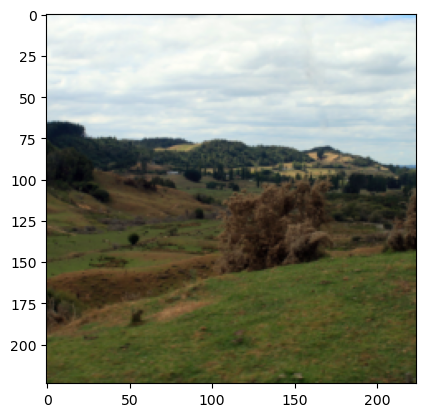

Distance(km):  115316.35884426464
Pred(token):  487b
True(latlng):  tensor(-38.3330) tensor(175.0754)


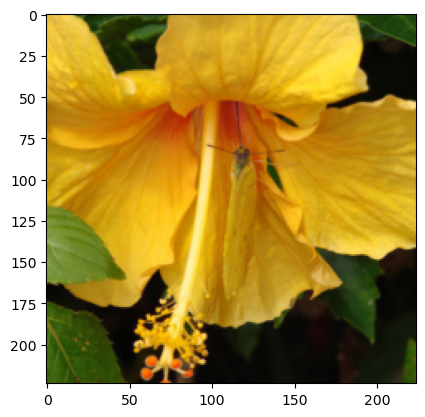

Distance(km):  115376.11790736194
Pred(token):  60014
True(latlng):  tensor(-19.7910) tensor(-44.1559)


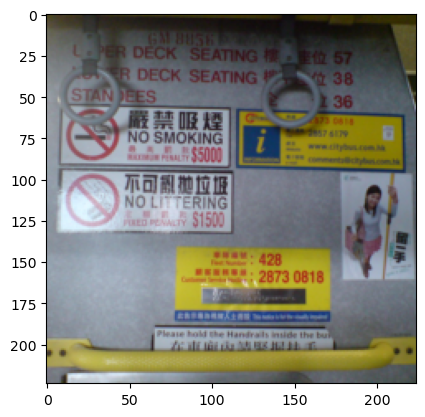

Distance(km):  115815.17547742226
Pred(token):  95a3
True(latlng):  tensor(22.2911) tensor(113.9414)


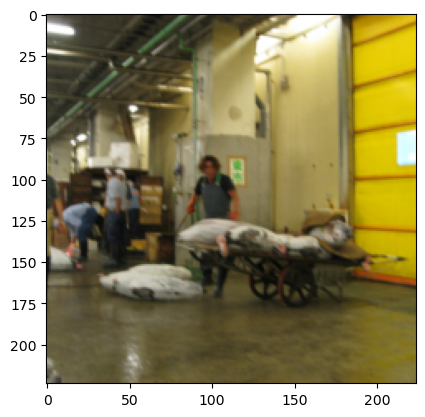

Distance(km):  115929.769436744
Pred(token):  95a3
True(latlng):  tensor(35.6634) tensor(139.7703)


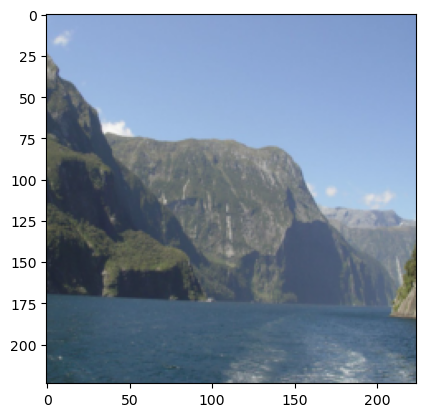

Distance(km):  116481.96844613315
Pred(token):  12cd
True(latlng):  tensor(-44.6061) tensor(168.2227)


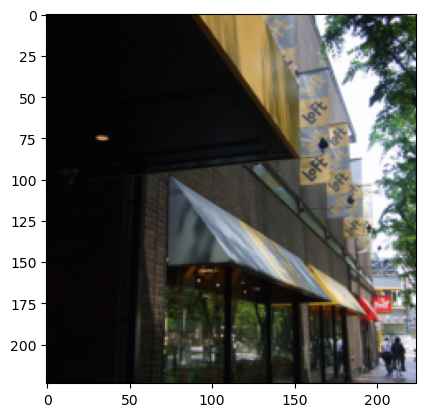

Distance(km):  118343.35695661159
Pred(token):  95a3
True(latlng):  tensor(34.7082) tensor(135.5000)


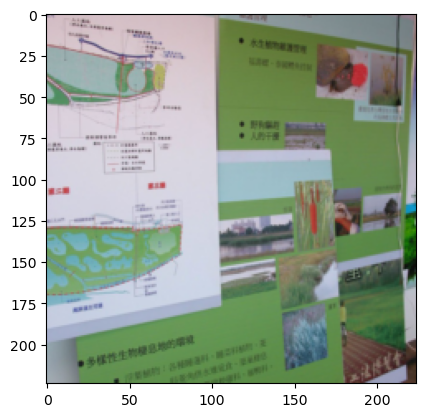

Distance(km):  119150.09506156047
Pred(token):  95a3
True(latlng):  tensor(25.0644) tensor(121.4746)


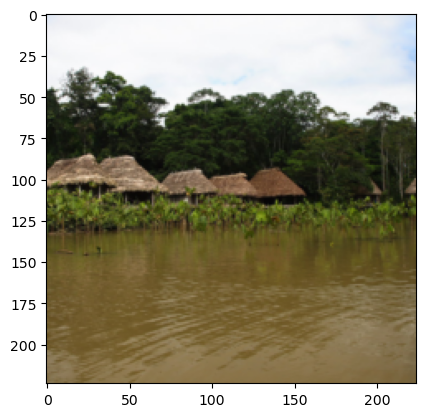

Distance(km):  119385.09409320605
Pred(token):  3175
True(latlng):  tensor(-2.5075) tensor(-76.8885)


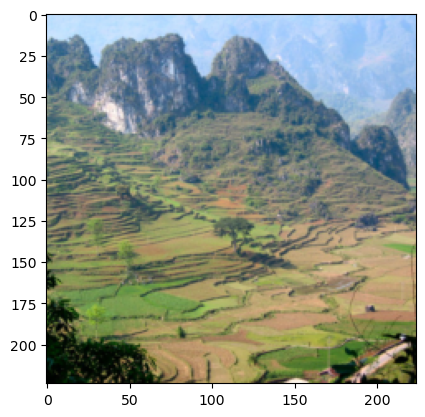

Distance(km):  119733.99661189389
Pred(token):  916d
True(latlng):  tensor(22.3813) tensor(105.9317)


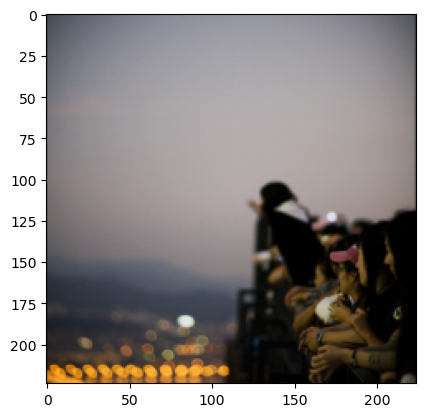

Distance(km):  122595.78755022681
Pred(token):  95a3
True(latlng):  tensor(37.5609) tensor(126.9855)


In [18]:
# Visualize the least accurate predictions
def visualize_predictions(heap):
    inv_normalize = T.Normalize(mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225], std=[1/0.229, 1/0.224, 1/0.225])

    while len(heap) > 0:
        example = heapq.heappop(heap)

        image = inv_normalize(example.img)
        plt.imshow(image.permute(1, 2, 0))
        plt.show()

        print("Distance(km): ", example.distance * 6378.0 * 2 * math.pi)
        print("Pred(token): ", example.pred_s2cell)
        print("True(latlng): ", example.lat, example.lng)

visualize_predictions(list(least_accurate_n))

In [45]:
class S2Annotator:
    def __init__(self, mapping):
        self.cell_set = set([s2sphere.CellId.from_token(token).id() for token in mapping.name_to_label.keys()])

    def get_cell(self, lat, lng):
        cell_id = s2sphere.CellId.from_lat_lng(s2sphere.LatLng.from_degrees(lat, lng))
        while cell_id.id() not in self.cell_set:
            if cell_id.level() == 0:
                return None
            cell_id = cell_id.parent()
        return cell_id.to_token()

# Return a list of predictions and a list of corresponding true labels
def prediction_labels(annotator, results):
    pred_labels = []
    true_labels = []
    for r in results.itertuples():
        true_token = annotator.get_cell(r.true_lat, r.true_lng)
        if true_token is None:
            continue
        
        pred_labels.append(im2gps2007.mapping.get_label(r.pred_token))
        true_labels.append(im2gps2007.mapping.get_label(true_token))

    return pred_labels, true_labels


# Compute and display confusion matrix
def confusion_matrix(annotator, results):
    pred_labels, true_labels = prediction_labels(annotator, results)
    confmat = torchmetrics.ConfusionMatrix(task="multiclass", num_classes=len(im2gps2007.mapping))
    return confmat(torch.Tensor(pred_labels), torch.Tensor(true_labels))

annotator = S2Annotator(im2gps2007.mapping)
cm = confusion_matrix(annotator, results)

#import seaborn
#seaborn.heatmap(cm.numpy(), annot=True)
#plt.matshow(cm.numpy())
#plt.show()
cm

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 1, 2,  ..., 0, 0, 0],
        [0, 0, 3,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 1, 0, 0],
        [0, 0, 0,  ..., 0, 3, 0],
        [0, 0, 0,  ..., 0, 0, 4]])

In [49]:
pred_labels, true_labels = prediction_labels(annotator, results)
len(pred_labels), len(true_labels)

(106622, 106622)

In [54]:
# Print 10 least accurate predictions, 10 most confused labels
def print_least_accurate_confused(pred_labels, true_labels):
    confused_counts = collections.Counter()
    for pred, true in zip(pred_labels, true_labels):
        if pred != true:
            confused_counts[true] += 1

    confused_labels = sorted(confused_counts.items(), key=lambda x: x[1], reverse=True)
    print("Most confused labels")
    for label, count in confused_labels[:10]:
        print(im2gps2007.mapping.get_name(label), count)

    #least_accurate = []
    #for pred, true in zip(pred_labels, true_labels):
    #    if pred != true:
    #        least_accurate.append((pred, true))

    #print("Least accurate predictions")
    #for pred, true in least_accurate[:10]:
    #    print(pred, true)

print_least_accurate_confused(pred_labels, true_labels)

Most confused labels
3442a9 488
88f505 349
35b2704 322
47b7 315
88dd4 312
357cb 307
60188bf 289
1dcc4 280
3baf 279
390d 270


In [56]:
# Print top most confused pairs
def print_top_confused_cm(cm):
    confusion = np.copy(cm.numpy())
    num_printed = 0
    while num_printed < 20:
        max_ix = np.unravel_index(np.argmax(confusion), confusion.shape)
        if max_ix[0] == 0:
            break
        if max_ix[0] == max_ix[1]:
            confusion[max_ix] = 0
            continue
        print(
            f"true = {im2gps2007.mapping.get_name(int(max_ix[0]))},"\
            f"pred = {im2gps2007.mapping.get_name(int(max_ix[1]))},"\
            f"count = {confusion[max_ix]}"
        )
        confusion[max_ix] = 0
        num_printed += 1

print_top_confused_cm(cm)

true = 47b7,pred = 4cc91bc,count = 61
true = 1dcc4,pred = 12cd,count = 47
true = 3442a9,pred = 4cc91a5,count = 46
true = 1499,pred = 12cd,count = 42
true = 133b4,pred = 12cd,count = 41
true = 134b,pred = 12cd,count = 39
true = 134d,pred = 12cd,count = 37
true = 0daf,pred = 12cd,count = 36
true = 3442a9,pred = 4cc91bc,count = 36
true = 88dd4,pred = 12cd,count = 35
true = 14a1bd1,pred = 12cd,count = 34
true = 470b,pred = 479f,count = 34
true = 88f505,pred = 12cd,count = 34
true = 12a4a2f4,pred = 12cd,count = 33
true = 14a1bd3,pred = 12cd,count = 33
true = 132a55,pred = 479f,count = 32
true = 1335,pred = 12cd,count = 32
true = 60014,pred = 4cc91bc,count = 32
true = 3442a9,pred = 12cd,count = 30
true = 88dd4,pred = 80dcc,count = 30
